# Prompt

First, you learned about the importance of transforming your data into a stationary series. You tested for stationarity using the adfuller function and interpreted the value of the hypothesis test. If the data was not stationary, you learned how to apply strategies, such as differencing and logarithmic transformations, to achieve stationarity.

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate p and q parameters of the model.

This activity asks you to identify a time series of interest to you and build an ARMA model to construct a basic forecast for the series and analyze the error. You might also consider building models with different p and q parameters because, while ACF and PACF plots are helpful, they provide rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these. 

Please find a time series dataset using any resource you would like, and present your model and findings to the class.  

If you have trouble locating a dataset or would prefer a suggestion, try the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) from Kaggle. This dataset involves forecasting retail store sales for a major drug store.

# Imports

In [1]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

from statsmodels.tsa.seasonal import seasonal_decompose, _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})
sns.set()

# Data Load

Looking at snowfall per month for Mammoth Mountain, from 1969 to the present, as obtained from  
- https://www.mammothmountain.com/on-the-mountain/snowfall-history

See [pre-processing notebook](./mammoth_snowfall_datagen.ipynb) for how I generated this table from the Mammoth website data

## Read In

In [3]:
df = pd.read_csv("./data/mammoth_mountain_snowfall_melted_table.csv")
df.head()

,Date,Month,Snow Fall
0,1970-01-01,Jan,78.0
1,1970-02-01,Feb,30.5
2,1970-03-01,Mar,46.0
3,1970-04-01,Apr,27.0
4,1970-05-01,May,0.0


In [4]:
df = pd.read_csv("./data/mammoth_mountain_snowfall_melted_table.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df

,Month,Snow Fall
Date,,
1970-01-01,Jan,78.0
1970-02-01,Feb,30.5
1970-03-01,Mar,46.0
1970-04-01,Apr,27.0
1970-05-01,May,0.0
...,...,...
2023-08-01,Aug,0.0
2023-09-01,Sep,0.0
2023-10-01,Oct,0.0


## Calculate Average Snowfall by Month

In [5]:
# monthly_average = df.groupby("Month")[["Snow Fall"]].agg(np.mean)
# monthly_average.rename(columns={"Snow Fall": "Monthly Average"}, inplace=True)
monthly_average = df.groupby("Month")[["Snow Fall"]].agg(
    MonthlyAverage=("Snow Fall", "mean")
)
monthly_average["Can Snow"] = (monthly_average["MonthlyAverage"] > 5.0).astype(int)
monthly_average

,MonthlyAverage,Can Snow
Month,,
Apr,32.924074,1
Aug,2.870370,0
Dec,66.411111,1
Feb,69.761111,1
Jan,71.333333,1
Jul,0.000000,0
Jun,0.190741,0
Mar,63.718519,1
May,8.029630,1


## And Insert into Data Frame for Use as Exo Feature

In [6]:
df = (
    df.reset_index()
    .set_index(["Date", "Month"])
    .join(monthly_average, how="outer")
    .reset_index()
    .set_index("Date")
)

In [7]:
df = df.reindex(pd.date_range(start=df.index[0], periods=len(df), freq="MS"))
df.index.set_names("Date", inplace=True)
df

,Month,Snow Fall,MonthlyAverage,Can Snow
Date,,,,
1970-01-01,Jan,78.0,71.333333,1
1970-02-01,Feb,30.5,69.761111,1
1970-03-01,Mar,46.0,63.718519,1
1970-04-01,Apr,27.0,32.924074,1
1970-05-01,May,0.0,8.029630,1
...,...,...,...,...
2023-08-01,Aug,0.0,2.870370,0
2023-09-01,Sep,0.0,2.870370,0
2023-10-01,Oct,0.0,6.372222,1


# Extract Target and Split

## Target

Arbitrarily limit from 2015 and on, to make the dataset easier to work with
- Also, stop it in May so that when predicting the last N months, we are finishing at the end of a ski season
- i.e. avoid trying to predict into the boring summer trough region

In [8]:
y_target = df["Snow Fall"]["2010":"2022-05-01"]
y_exog = df["MonthlyAverage"][y_target.index]
# y_exog = df["Can Snow"][y_target.index]
# y_exog = df[["MonthlyAverage", "Can Snow"]].loc[y_target.index, :]

## Train / Test Split

In [9]:
n_steps_future = 7

In [10]:
# Split
y_history, y_future, y_exog_history, y_exog_future = train_test_split(
    y_target, y_exog, shuffle=False, test_size=n_steps_future
)

if 0:
    # Disable exogenous features
    y_exog_history, y_exog_future = None, None

# Plots of Data

## Raw Data

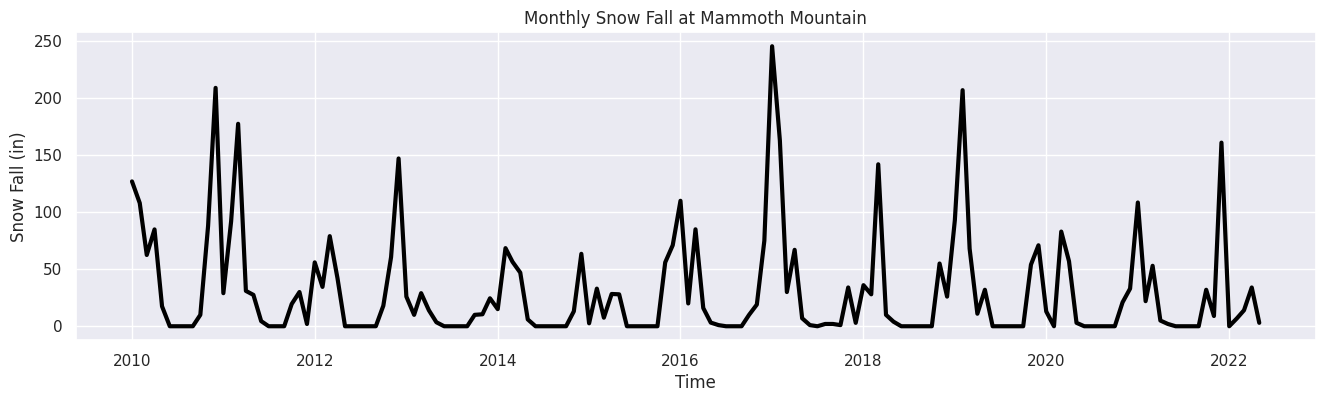

In [11]:
plt.figure(figsize=(16, 4))
plt.plot(y_target, color="black", lw=3)
plt.title("Monthly Snow Fall at Mammoth Mountain")
plt.xlabel("Time")
plt.ylabel("Snow Fall (in)")
plt.show()

## Seasonals

In [12]:
snowfall_period = 12

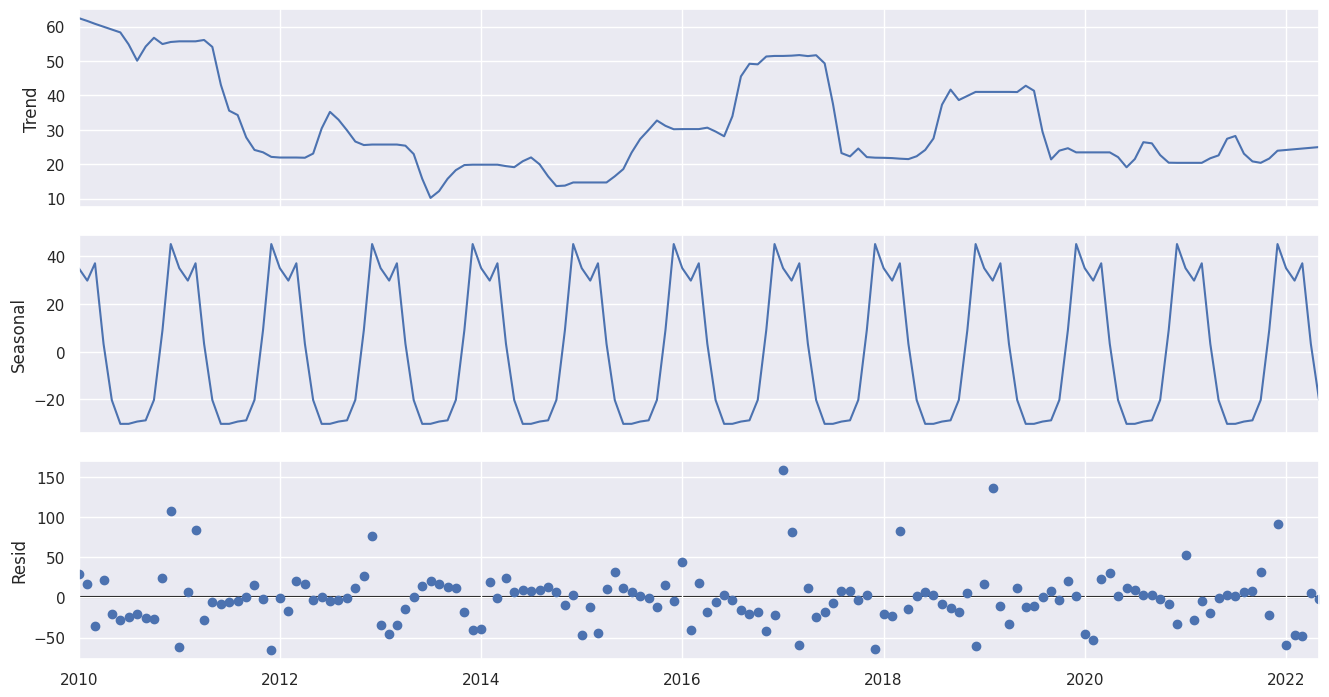

In [13]:
seasonal_decompose(
    y_target,
    model="additive",
    period=snowfall_period,
    extrapolate_trend=snowfall_period,
).plot(observed=False).set_size_inches((15, 7.5))

plt.show()

## Autocorrelation

In [14]:
def plot_acf_pacf(y):
    (fig, ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    plot_acf(y, lags=10, ax=ax[0])
    ax[0].set_title("ACF - MA(q)")
    ax[0].set_xlabel("Lag")
    ax[0].set_ylabel("Corr")

    plot_pacf(y, lags=10, ax=ax[1])
    ax[1].set_title("PACF - AR(p)")
    ax[1].set_xlabel("Lag")
    ax[1].set_ylabel("Corr")
    plt.show()

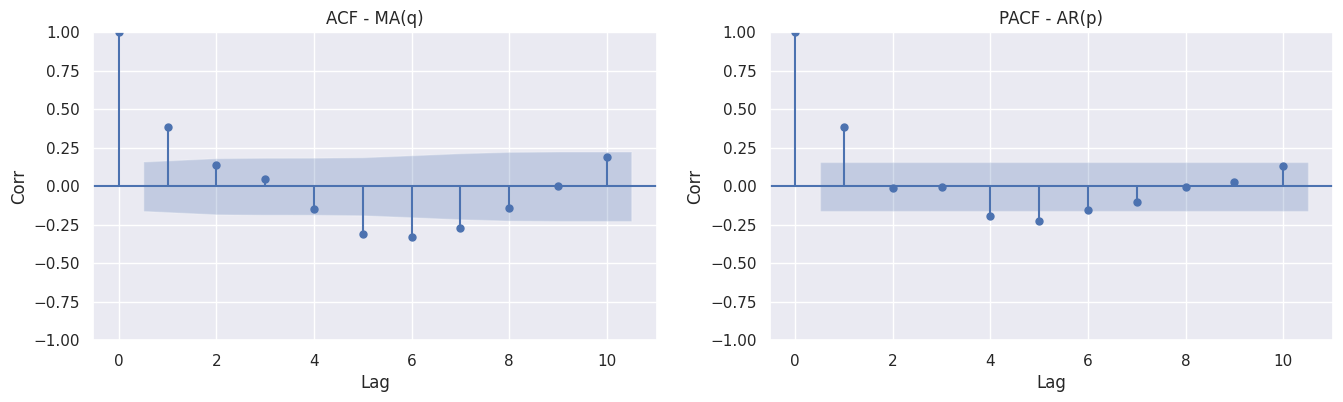

In [15]:
plot_acf_pacf(y_target)

# Fit with ARIMA

## Helper Functions

In [16]:
def get_errors_dict(y_true, y_pred):
    return {
        "mae": mean_absolute_error(y_true, y_pred).round(1),
        "rmse": root_mean_squared_error(y_true, y_pred).round(1),
    }

In [17]:
def get_estimator_and_errors(order, seasonal_order):
    # Fit
    estimator = ARIMA(
        y_history,
        order=order,
        seasonal_order=seasonal_order,
        exog=y_exog_history,
    ).fit()

    # Predict history and future
    y_hat = estimator.predict(
        start=y_history.index[0], end=y_future.index[-1], exog=y_exog_future
    )

    # Get errors
    (y_fit, y_forecast) = train_test_split(
        y_hat,
        shuffle=False,
        test_size=len(y_future),
    )

    train_test_errors = {
        "fit": get_errors_dict(y_history, y_fit),
        "forecast": get_errors_dict(y_future, y_forecast),
    }

    return estimator, y_hat, train_test_errors

## Search Grid

Over (p, d, q) for stationary and (p, d, q, **s**) for seasonal, with s fixed to known period

In [18]:
p_list = range(1, 3)
d_list = range(1)
q_list = range(1, 3)

sp_list = range(1, 3)
sd_list = range(1)
sq_list = range(1, 3)

In [19]:
best_error, best_order, best_seasonal_order = (
    np.Inf,
    None,
    None,
)

In [20]:
if 1:  # enable to bypass search and use saved best
    best_order, best_seasonal_order = (1, 0, 1), (2, 0, 2, snowfall_period)
    print(
        "Bypassing search and using order = %s, seasonal_order = %s"
        % (
            best_order,
            best_seasonal_order,
        )
    )

Bypassing search and using order = (1, 0, 1), seasonal_order = (2, 0, 2, 12)


## Run the Search

In [21]:
if best_order is None:
    for p in p_list:
        for d in d_list:
            for q in q_list:
                for sp in sp_list:
                    for sd in sd_list:
                        for sq in sq_list:
                            order = (p, d, q)
                            seasonal_order = (sp, sd, sq, snowfall_period)
                            estimator, y_hat, train_test_errors = (
                                get_estimator_and_errors(order, seasonal_order)
                            )

                            current_error = train_test_errors["forecast"]["mae"]
                            if current_error < best_error:
                                best_error = current_error
                                best_order = order
                                best_seasonal_order = seasonal_order
                                print(
                                    "New best at order = %s, seasonal_order = %s\n\tAll errors = %s"
                                    % (
                                        best_order,
                                        best_seasonal_order,
                                        str(train_test_errors),
                                    )
                                )

```
New best at order = (1, 0, 1), seasonal_order = (1, 0, 1, 12)
	All errors = {'fit': {'mae': 20.1, 'rmse': 34.0}, 'forecast': {'mae': 43.6, 'rmse': 51.5}}
New best at order = (1, 0, 1), seasonal_order = (1, 0, 2, 12)
	All errors = {'fit': {'mae': 20.5, 'rmse': 33.7}, 'forecast': {'mae': 38.9, 'rmse': 49.0}}
New best at order = (1, 0, 1), seasonal_order = (2, 0, 2, 12)
	All errors = {'fit': {'mae': 20.0, 'rmse': 33.3}, 'forecast': {'mae': 37.7, 'rmse': 46.0}}
```

## Evaluate Best Model

In [22]:
estimator, y_hat, train_test_errors = get_estimator_and_errors(
    best_order, best_seasonal_order
)

In [23]:
print(
    "Evaluated model at order = %s, seasonal_order = %s\n\tAll errors = %s"
    % (
        best_order,
        best_seasonal_order,
        str(train_test_errors),
    )
)

Evaluated model at order = (1, 0, 1), seasonal_order = (2, 0, 2, 12)
	All errors = {'fit': {'mae': 20.0, 'rmse': 33.3}, 'forecast': {'mae': 37.7, 'rmse': 46.0}}


```
Evaluated model at order = (1, 0, 1), seasonal_order = (2, 0, 2, 12)
	All errors = {'fit': {'mae': 20.0, 'rmse': 33.3}, 'forecast': {'mae': 37.7, 'rmse': 46.0}}
```

# Compare Result to Saved Copy

Don't want to see a change here unless we intended one

## Read Saved Copy Back

In [24]:
saved_results_filename = "./data/monthly_snowfall_arima_with_exog.csv"
if not os.path.exists(saved_results_filename):
    print("Writing new results checkpoint to file %s" % saved_results_filename)
    y_hat.to_csv(saved_results_filename, index_label="Date")

In [25]:
y_hat_saved = pd.read_csv(saved_results_filename, index_col="Date", parse_dates=True)[
    y_hat.name
]

if 0:  # enable to demonstrate possible to regression assessment
    y_hat_saved[15] += 1.0e-3

## Plot if Different

In [26]:
if not np.allclose(y_hat, y_hat_saved):
    plt.figure(figsize=(16, 4))
    plt.plot(
        y_hat_saved,
        label="Saved %s" % str(get_errors_dict(y_target, y_hat_saved)),
        color="black",
        lw=7,
    )
    plt.plot(
        y_hat,
        label="Current %s" % str(get_errors_dict(y_target, y_hat)),
        color="cyan",
        lw=2,
    )
    plt.title(
        "Current Result Different from Saved - diff errors = %s"
        % str(get_errors_dict(y_hat, y_hat_saved))
    )
    plt.legend()

## Assert Not Different

Force interrupt here to get eyes on what is happening

In [27]:
# pd.concat([y_hat, y_hat_saved], axis=1)

In [28]:
pd.testing.assert_series_equal(y_hat, y_hat_saved, check_names=False, check_freq=False)

# Plots of Model Quality

## Data from Previous Model to Compare

In [29]:
saved_results_previous_model_filename = "./data/monthly_snowfall_arima_without_exog.csv"
y_hat_without_exog = pd.read_csv(
    saved_results_previous_model_filename, index_col="Date", parse_dates=True
)[y_hat.name]

## Also get a dynamic prediction starting by number of steps into past

Just for fun. To show what happens if you start *forecasting* using data from in sample set
- I think what this means is that you switch to open loop earlier than you need to

In [30]:
y_hat_history_tail_dynamic = estimator.predict(
    start=y_history.index[-n_steps_future - 1],
    end=y_future.index[-1],
    dynamic=0,
    exog=y_exog_future,
)

## Current Fit

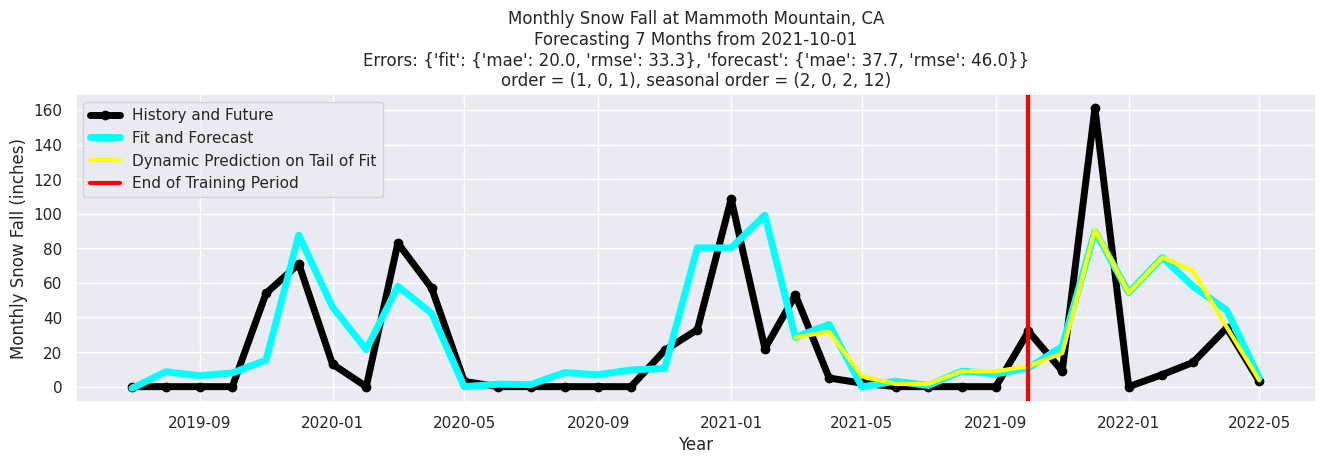

In [40]:
nplot = len(y_target) - n_steps_future
nplot = 4 * n_steps_future

plt.figure(figsize=(16, 4))
plt.plot(
    y_target.tail(nplot + n_steps_future),
    color="black",
    label="History and Future",
    linestyle="solid",
    marker="o",
    lw=5,
)
plt.plot(
    y_hat.tail(nplot + n_steps_future),
    color="cyan",
    label="Fit and Forecast",
    linestyle="solid",
    lw=5,
)

plt.plot(
    y_hat_history_tail_dynamic,
    color="yellow",
    label="Dynamic Prediction on Tail of Fit",
    linestyle="solid",
    lw=3,
)

if 0:
    plt.plot(
        y_hat_without_exog.tail(nplot + n_steps_future),
        color="purple",
        label="Fit and Forecast - No Exog",
        linestyle="solid",
        lw=3,
    )

plt.axvline(
    y_target.index[-n_steps_future - 1],
    color="red",
    label="End of Training Period",
    lw=3,
)

plt.title(
    "Monthly Snow Fall at Mammoth Mountain, CA\nForecasting %d Months from %s\nErrors: %s\norder = %s, seasonal order = %s"
    % (
        n_steps_future,
        str(y_target.index[-n_steps_future - 1]).split()[0],
        str(train_test_errors),
        str(best_order),
        str(best_seasonal_order),
    )
)

plt.xlabel("Year")
plt.ylabel("Monthly Snow Fall (inches)")
plt.legend(loc="upper left")
plt.show()

## Comparing to Prior Run without Exo

Look at how the stuff that is supposed to be zero is now pulled down to nearly zero, at the cost of some peak clipping

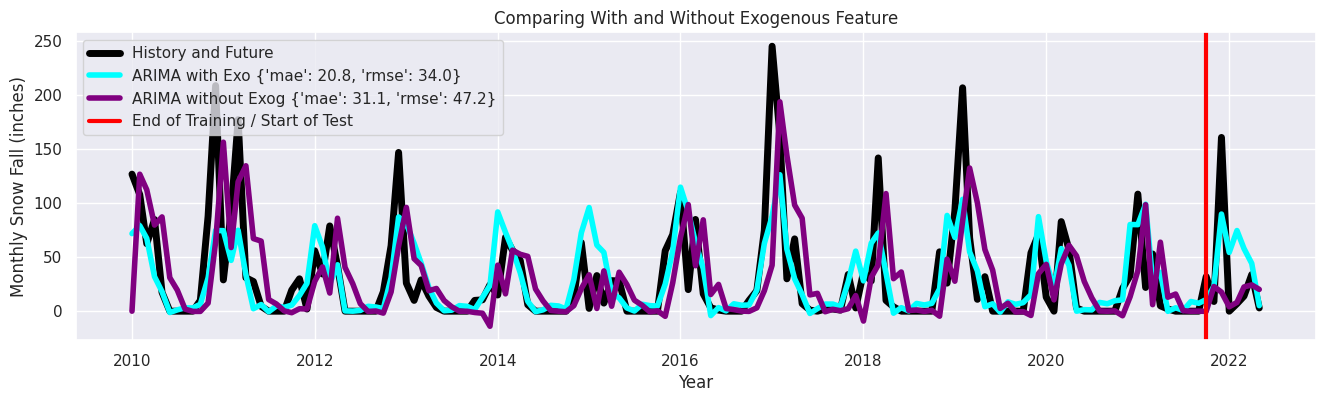

In [32]:
plt.figure(figsize=(16, 4))
plt.plot(y_target, label="History and Future", color="black", lw=5)
plt.plot(
    y_hat,
    label="ARIMA with Exo %s" % str(get_errors_dict(y_target, y_hat)),
    color="cyan",
    lw=4,
)
plt.plot(
    y_hat_without_exog,
    label="ARIMA without Exog %s" % str(get_errors_dict(y_target, y_hat_without_exog)),
    color="purple",
    lw=4,
)
plt.axvline(
    y_target.index[-n_steps_future - 1],
    color="red",
    label="End of Training / Start of Test",
    lw=3,
)

plt.title("Comparing With and Without Exogenous Feature")

plt.xlabel("Year")
plt.ylabel("Monthly Snow Fall (inches)")
plt.legend(loc="upper left")
plt.show()

## Autocorrelation of Residual

Look ma, no non-zero corr coefs

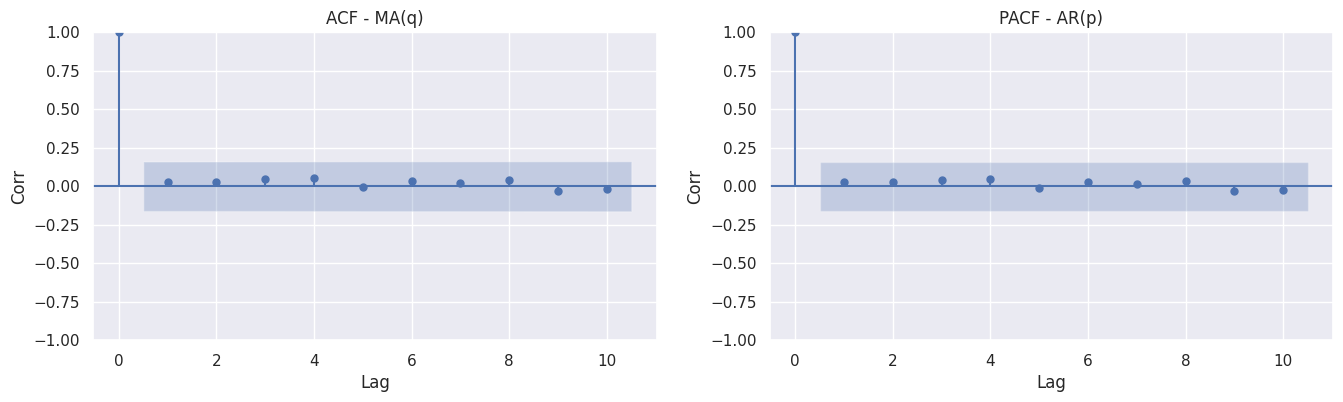

In [33]:
plot_acf_pacf(y_target - y_hat)